``application_{train|test}.csv``
- Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
- Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

``bureau.csv``
- Tous les crédits antérieurs du client fournis par d'autres institutions financières qui ont été signalés au bureau de crédit     (pour les clients qui ont un prêt dans notre échantillon).
- Pour chaque prêt de notre échantillon, il y a autant de lignes que le nombre de crédits que le client avait dans le Credit     
  Bureau avant la date de la demande.

``bureau_balance.csv``
- Soldes mensuels des crédits antérieurs au bureau de crédit.
- Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent signalé au bureau de crédit - c'est-     à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois où nous avons un historique   observable pour les crédits précédents) lignes .

``POS_CASH_balance.csv``
- Instantanés mensuels du solde des points de vente précédents et des prêts en espèces que le demandeur avait contractés avec  Home Credit.
- Ce tableau a une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de crédits précédents relatifs * # de mois dans lequel nous avons un historique observable pour les lignes des crédits précédents).

``credit_card_balance.csv``
- Aperçus mensuels du solde des cartes de crédit précédentes que le demandeur a avec Home Credit.
- Ce tableau comporte une ligne pour chaque mois d'historique de chaque crédit précédent dans Home Credit (crédit à la consommation et prêts de trésorerie) lié aux prêts de notre échantillon - c'est-à-dire que le tableau a (#prêts dans l'échantillon * # de cartes de crédit précédentes relatives * # de mois où nous avons un historique observable pour la carte de crédit précédente) lignes.

``previous_application.csv``
- Toutes les demandes précédentes de prêts immobiliers des clients qui ont des prêts dans notre échantillon.
- Il y a une ligne pour chaque demande précédente liée aux prêts dans notre échantillon de données.

`installments_payments.csv``
- Historique de remboursement des crédits précédemment décaissés en Home Credit liés aux prêts de notre échantillon.
  Il y a a) une ligne pour chaque paiement effectué plus b) une ligne pour chaque paiement manqué.
- Une ligne équivaut à un versement d'une échéance OU une échéance correspondant à un versement d'un précédent crédit immobilier  lié aux prêts de notre échantillon.

``HomeCredit_columns_description.csv``
- Ce fichier contient les descriptions des colonnes des différents fichiers de données.


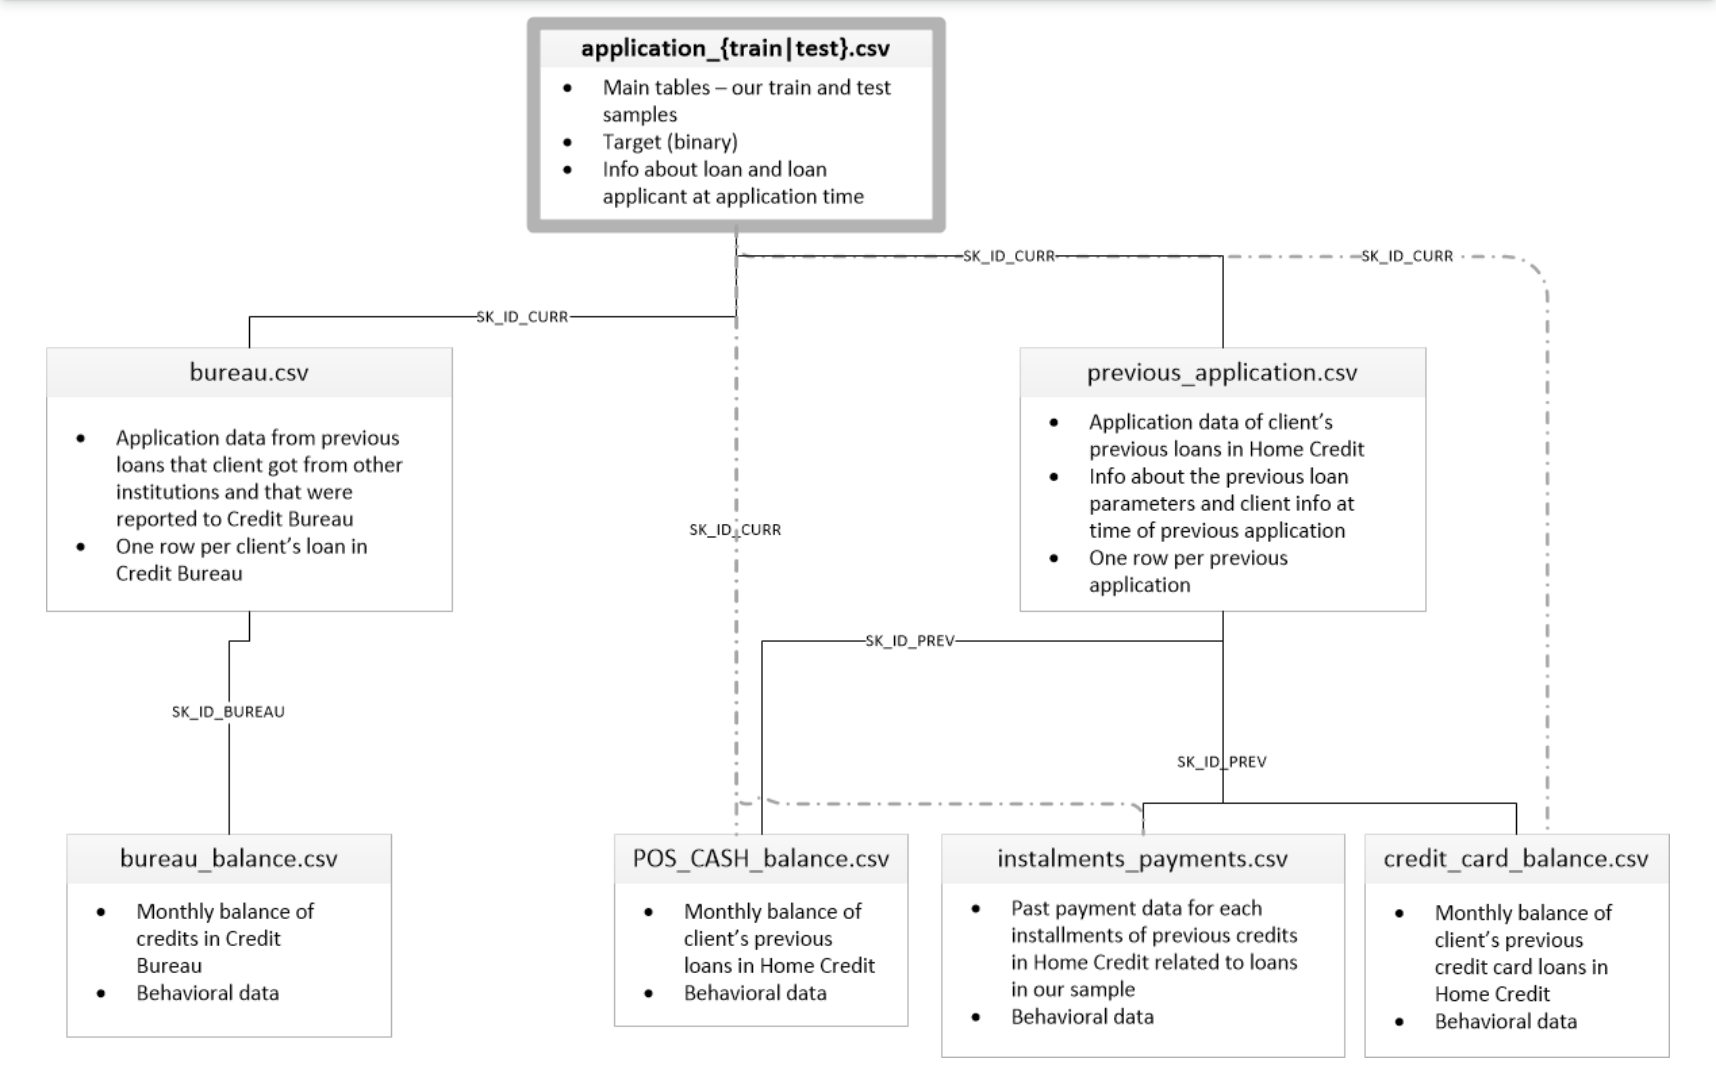

https://www.kaggle.com/c/home-credit-default-risk/data (lien de la data)

Inspiré du kernel : https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook
https://www.kaggle.com/code/danilz/merge-all-data-base-glm-vs-xgb-explained-0-763/notebook

In [1]:
!pip install lime

In [2]:
!pip install hyperopt

In [3]:
!pip install xgboost

In [4]:
# numpy et pandas pour la manipulation de données
import numpy as np
import pandas as pd 

# prétraitement sklearn pour traiter les variables catégorielles
from sklearn.preprocessing import LabelEncoder

# Gestion du système de fichiers
import os

# Supprimer les avertissements 
import warnings
warnings.filterwarnings('ignore')

# matplotlib et seaborn pour le traçage
import matplotlib.pyplot as plt
import seaborn as sns


import gc
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Transformations de variables
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer

# Feature engineering
import featuretools as ft
from featuretools import selection

# Package pour augmenter la data
from imblearn.over_sampling import SMOTE
#Preprocessing, Upsampling, Model Selection, Model Evaluation
from sklearn.model_selection import train_test_split, StratifiedKFold


1. Importation des datasets 
2. Analyse exploratoire
 2.1. Difference entre les deux data(le train et le test)
  2.1.1 Analyse univariée du target
 2.2 Concatenation des data train et test et analyse des variables
  2.2.1 Analyse statistique des variables de types objets 
  2.2.2 Analyse statistique des variables de types numeriques 
  

In [5]:
data_application_test = pd.read_csv ('application_test.csv')
data_application_train = pd.read_csv ('application_train.csv')

In [6]:
print('Shape train:' ,data_application_train.shape )
print('Shape test :' ,data_application_test.shape )

Shape train: (307511, 122)
Shape test : (48744, 121)


In [7]:
data_bureau = pd.read_csv ('bureau.csv')
data_bureau_balance = pd.read_csv ('bureau_balance.csv')
data_credit_card_balance = pd.read_csv ('credit_card_balance.csv')
data_installments_payments = pd.read_csv ('installments_payments.csv')
data_POS_CASH_balance = pd.read_csv ('POS_CASH_balance.csv')
data_previous_application = pd.read_csv ('previous_application.csv')
data_sample_submission = pd.read_csv ('sample_submission.csv')
description = pd.read_csv('HomeCredit_columns_description.csv',  encoding="ISO-8859-1")

In [8]:
print('Shape bureau:' ,data_bureau.shape )
print('Shape bureau_balance :' ,data_bureau_balance.shape )
print('Shape credit_card_balance:' ,data_credit_card_balance.shape )
print('Shape installments_payments :' ,data_installments_payments.shape )
print('Shape POS_CASH_balance:' ,data_POS_CASH_balance.shape )
print('Shape previous_application :' ,data_previous_application.shape )
print('Shape sample_submission:' ,data_sample_submission.shape )
print('Shape description:' ,description.shape )

Shape bureau: (1716428, 17)
Shape bureau_balance : (27299925, 3)
Shape credit_card_balance: (3840312, 23)
Shape installments_payments : (13605401, 8)
Shape POS_CASH_balance: (10001358, 8)
Shape previous_application : (1670214, 37)
Shape sample_submission: (48744, 2)
Shape description: (219, 5)


In [9]:
data_application_train.head(3)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
data_application_test.head(3)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0


In [11]:
data_bureau.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN


In [12]:
data_bureau_balance.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


In [13]:
data_credit_card_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,...,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,...,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,...,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0


In [14]:
data_installments_payments.head(3)

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000


In [15]:
data_POS_CASH_balance.head(3)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0


In [16]:
data_previous_application.head(3)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0


In [17]:
data_sample_submission.head(3)

,SK_ID_CURR,TARGET
0,100001,0.5
1,100005,0.5
2,100013,0.5


In [18]:
description.head(3)

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,2,application_{train|test}.csv,TARGET,Target variable (1 - client with payment diffi...,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN


In [19]:
data_application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,307511.000000,307511.000000,307511.000000,3.075110e+05,3.075110e+05,307499.000000,3.072330e+05,307511.000000,307511.000000,307511.000000,...,307511.000000,307511.000000,307511.000000,307511.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000,265992.000000
mean,278180.518577,0.080729,0.417052,1.687979e+05,5.990260e+05,27108.573909,5.383962e+05,0.020868,-16036.995067,63815.045904,...,0.008130,0.000595,0.000507,0.000335,0.006402,0.007000,0.034362,0.267395,0.265474,1.899974
std,102790.175348,0.272419,0.722121,2.371231e+05,4.024908e+05,14493.737315,3.694465e+05,0.013831,4363.988632,141275.766519,...,0.089798,0.024387,0.022518,0.018299,0.083849,0.110757,0.204685,0.916002,0.794056,1.869295
min,100002.000000,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,4.050000e+04,0.000290,-25229.000000,-17912.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,189145.500000,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,2.385000e+05,0.010006,-19682.000000,-2760.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,278202.000000,0.000000,0.000000,1.471500e+05,5.135310e+05,24903.000000,4.500000e+05,0.018850,-15750.000000,-1213.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,367142.500000,0.000000,1.000000,2.025000e+05,8.086500e+05,34596.000000,6.795000e+05,0.028663,-12413.000000,-289.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,456255.000000,1.000000,19.000000,1.170000e+08,4.050000e+06,258025.500000,4.050000e+06,0.072508,-7489.000000,365243.000000,...,1.000000,1.000000,1.000000,1.000000,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


### Les variables ``DAYS_BIRTH``, ``DAYS_EMPLOYED`` ont des valeurs negatives.

In [20]:
data_application_test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,48744.000000,48744.000000,4.874400e+04,4.874400e+04,48720.000000,4.874400e+04,48744.000000,48744.000000,48744.000000,48744.000000,...,48744.000000,48744.0,48744.0,48744.0,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000,42695.000000
mean,277796.676350,0.397054,1.784318e+05,5.167404e+05,29426.240209,4.626188e+05,0.021226,-16068.084605,67485.366322,-4967.652716,...,0.001559,0.0,0.0,0.0,0.002108,0.001803,0.002787,0.009299,0.546902,1.983769
std,103169.547296,0.709047,1.015226e+05,3.653970e+05,16016.368315,3.367102e+05,0.014428,4325.900393,144348.507136,3552.612035,...,0.039456,0.0,0.0,0.0,0.046373,0.046132,0.054037,0.110924,0.693305,1.838873
min,100001.000000,0.000000,2.694150e+04,4.500000e+04,2295.000000,4.500000e+04,0.000253,-25195.000000,-17463.000000,-23722.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,188557.750000,0.000000,1.125000e+05,2.606400e+05,17973.000000,2.250000e+05,0.010006,-19637.000000,-2910.000000,-7459.250000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,277549.000000,0.000000,1.575000e+05,4.500000e+05,26199.000000,3.960000e+05,0.018850,-15785.000000,-1293.000000,-4490.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,367555.500000,1.000000,2.250000e+05,6.750000e+05,37390.500000,6.300000e+05,0.028663,-12496.000000,-296.000000,-1901.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000
max,456250.000000,20.000000,4.410000e+06,2.245500e+06,180576.000000,2.245500e+06,0.072508,-7338.000000,365243.000000,0.000000,...,1.000000,0.0,0.0,0.0,2.000000,2.000000,2.000000,6.000000,7.000000,17.000000


In [21]:
data_bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1.716428e+06,1.716428e+06,1.716428e+06,1.716428e+06,1.610875e+06,1.082775e+06,5.919400e+05,1.716428e+06,1.716415e+06,1.458759e+06,1.124648e+06,1.716428e+06,1.716428e+06,4.896370e+05
mean,2.782149e+05,5.924434e+06,-1.142108e+03,8.181666e-01,5.105174e+02,-1.017437e+03,3.825418e+03,6.410406e-03,3.549946e+05,1.370851e+05,6.229515e+03,3.791276e+01,-5.937483e+02,1.571276e+04
std,1.029386e+05,5.322657e+05,7.951649e+02,3.654443e+01,4.994220e+03,7.140106e+02,2.060316e+05,9.622391e-02,1.149811e+06,6.774011e+05,4.503203e+04,5.937650e+03,7.207473e+02,3.258269e+05
min,1.000010e+05,5.000000e+06,-2.922000e+03,0.000000e+00,-4.206000e+04,-4.202300e+04,0.000000e+00,0.000000e+00,0.000000e+00,-4.705600e+06,-5.864061e+05,0.000000e+00,-4.194700e+04,0.000000e+00
25%,1.888668e+05,5.463954e+06,-1.666000e+03,0.000000e+00,-1.138000e+03,-1.489000e+03,0.000000e+00,0.000000e+00,5.130000e+04,0.000000e+00,0.000000e+00,0.000000e+00,-9.080000e+02,0.000000e+00
50%,2.780550e+05,5.926304e+06,-9.870000e+02,0.000000e+00,-3.300000e+02,-8.970000e+02,0.000000e+00,0.000000e+00,1.255185e+05,0.000000e+00,0.000000e+00,0.000000e+00,-3.950000e+02,0.000000e+00
75%,3.674260e+05,6.385681e+06,-4.740000e+02,0.000000e+00,4.740000e+02,-4.250000e+02,0.000000e+00,0.000000e+00,3.150000e+05,4.015350e+04,0.000000e+00,0.000000e+00,-3.300000e+01,1.350000e+04
max,4.562550e+05,6.843457e+06,0.000000e+00,2.792000e+03,3.119900e+04,0.000000e+00,1.159872e+08,9.000000e+00,5.850000e+08,1.701000e+08,4.705600e+06,3.756681e+06,3.720000e+02,1.184534e+08


In [22]:
data_bureau_balance.describe()

,SK_ID_BUREAU,MONTHS_BALANCE
count,2.729992e+07,2.729992e+07
mean,6.036297e+06,-3.074169e+01
std,4.923489e+05,2.386451e+01
min,5.001709e+06,-9.600000e+01
25%,5.730933e+06,-4.600000e+01
50%,6.070821e+06,-2.500000e+01
75%,6.431951e+06,-1.100000e+01
max,6.842888e+06,0.000000e+00


In [23]:
data_credit_card_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,...,3.840312e+06,3.840312e+06,3.840312e+06,3.090496e+06,3.840312e+06,3.090496e+06,3.090496e+06,3.535076e+06,3.840312e+06,3.840312e+06
mean,1.904504e+06,2.783242e+05,-3.452192e+01,5.830016e+04,1.538080e+05,5.961325e+03,7.433388e+03,2.881696e+02,2.968805e+03,3.540204e+03,...,5.596588e+04,5.808881e+04,5.809829e+04,3.094490e-01,7.031439e-01,4.812496e-03,5.594791e-01,2.082508e+01,9.283667e+00,3.316220e-01
std,5.364695e+05,1.027045e+05,2.666775e+01,1.063070e+05,1.651457e+05,2.822569e+04,3.384608e+04,8.201989e+03,2.079689e+04,5.600154e+03,...,1.025336e+05,1.059654e+05,1.059718e+05,1.100401e+00,3.190347e+00,8.263861e-02,3.240649e+00,2.005149e+01,9.751570e+01,2.147923e+01
min,1.000018e+06,1.000060e+05,-9.600000e+01,-4.202502e+05,0.000000e+00,-6.827310e+03,-6.211620e+03,0.000000e+00,0.000000e+00,0.000000e+00,...,-4.233058e+05,-4.202502e+05,-4.202502e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434385e+06,1.895170e+05,-5.500000e+01,0.000000e+00,4.500000e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00
50%,1.897122e+06,2.783960e+05,-2.800000e+01,0.000000e+00,1.125000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,2.369328e+06,3.675800e+05,-1.100000e+01,8.904669e+04,1.800000e+05,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.633911e+03,...,8.535924e+04,8.889949e+04,8.891451e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00
max,2.843496e+06,4.562500e+05,-1.000000e+00,1.505902e+06,1.350000e+06,2.115000e+06,2.287098e+06,1.529847e+06,2.239274e+06,2.028820e+05,...,1.472317e+06,1.493338e+06,1.493338e+06,5.100000e+01,1.650000e+02,1.200000e+01,1.650000e+02,1.200000e+02,3.260000e+03,3.260000e+03


In [24]:
data_installments_payments.describe()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
count,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360540e+07,1.360250e+07,1.360540e+07,1.360250e+07
mean,1.903365e+06,2.784449e+05,8.566373e-01,1.887090e+01,-1.042270e+03,-1.051114e+03,1.705091e+04,1.723822e+04
std,5.362029e+05,1.027183e+05,1.035216e+00,2.666407e+01,8.009463e+02,8.005859e+02,5.057025e+04,5.473578e+04
min,1.000001e+06,1.000010e+05,0.000000e+00,1.000000e+00,-2.922000e+03,-4.921000e+03,0.000000e+00,0.000000e+00
25%,1.434191e+06,1.896390e+05,0.000000e+00,4.000000e+00,-1.654000e+03,-1.662000e+03,4.226085e+03,3.398265e+03
50%,1.896520e+06,2.786850e+05,1.000000e+00,8.000000e+00,-8.180000e+02,-8.270000e+02,8.884080e+03,8.125515e+03
75%,2.369094e+06,3.675300e+05,1.000000e+00,1.900000e+01,-3.610000e+02,-3.700000e+02,1.671021e+04,1.610842e+04
max,2.843499e+06,4.562550e+05,1.780000e+02,2.770000e+02,-1.000000e+00,-1.000000e+00,3.771488e+06,3.771488e+06


In [25]:
data_POS_CASH_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,1.000136e+07,1.000136e+07,1.000136e+07,9.975287e+06,9.975271e+06,1.000136e+07,1.000136e+07
mean,1.903217e+06,2.784039e+05,-3.501259e+01,1.708965e+01,1.048384e+01,1.160693e+01,6.544684e-01
std,5.358465e+05,1.027637e+05,2.606657e+01,1.199506e+01,1.110906e+01,1.327140e+02,3.276249e+01
min,1.000001e+06,1.000010e+05,-9.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.434405e+06,1.895500e+05,-5.400000e+01,1.000000e+01,3.000000e+00,0.000000e+00,0.000000e+00
50%,1.896565e+06,2.786540e+05,-2.800000e+01,1.200000e+01,7.000000e+00,0.000000e+00,0.000000e+00
75%,2.368963e+06,3.674290e+05,-1.300000e+01,2.400000e+01,1.400000e+01,0.000000e+00,0.000000e+00
max,2.843499e+06,4.562550e+05,-1.000000e+00,9.200000e+01,8.500000e+01,4.231000e+03,3.595000e+03


In [26]:
data_previous_application.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,...,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1.670214e+06,1.670214e+06,1.297979e+06,1.670214e+06,1.670213e+06,7.743700e+05,1.284699e+06,1.670214e+06,1.670214e+06,774370.000000,...,5951.000000,1.670214e+06,1.670214e+06,1.297984e+06,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000,997149.000000
mean,1.923089e+06,2.783572e+05,1.595512e+04,1.752339e+05,1.961140e+05,6.697402e+03,2.278473e+05,1.248418e+01,9.964675e-01,0.079637,...,0.773503,-8.806797e+02,3.139511e+02,1.605408e+01,342209.855039,13826.269337,33767.774054,76582.403064,81992.343838,0.332570
std,5.325980e+05,1.028148e+05,1.478214e+04,2.927798e+05,3.185746e+05,2.092150e+04,3.153966e+05,3.334028e+00,5.932963e-02,0.107823,...,0.100879,7.790997e+02,7.127443e+03,1.456729e+01,88916.115834,72444.869708,106857.034789,149647.415123,153303.516729,0.471134
min,1.000001e+06,1.000010e+05,0.000000e+00,0.000000e+00,0.000000e+00,-9.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-0.000015,...,0.373150,-2.922000e+03,-1.000000e+00,0.000000e+00,-2922.000000,-2892.000000,-2801.000000,-2889.000000,-2874.000000,0.000000
25%,1.461857e+06,1.893290e+05,6.321780e+03,1.872000e+04,2.416050e+04,0.000000e+00,5.084100e+04,1.000000e+01,1.000000e+00,0.000000,...,0.715645,-1.300000e+03,-1.000000e+00,6.000000e+00,365243.000000,-1628.000000,-1242.000000,-1314.000000,-1270.000000,0.000000
50%,1.923110e+06,2.787145e+05,1.125000e+04,7.104600e+04,8.054100e+04,1.638000e+03,1.123200e+05,1.200000e+01,1.000000e+00,0.051605,...,0.835095,-5.810000e+02,3.000000e+00,1.200000e+01,365243.000000,-831.000000,-361.000000,-537.000000,-499.000000,0.000000
75%,2.384280e+06,3.675140e+05,2.065842e+04,1.803600e+05,2.164185e+05,7.740000e+03,2.340000e+05,1.500000e+01,1.000000e+00,0.108909,...,0.852537,-2.800000e+02,8.200000e+01,2.400000e+01,365243.000000,-411.000000,129.000000,-74.000000,-44.000000,1.000000
max,2.845382e+06,4.562550e+05,4.180581e+05,6.905160e+06,6.905160e+06,3.060045e+06,6.905160e+06,2.300000e+01,1.000000e+00,1.000000,...,1.000000,-1.000000e+00,4.000000e+06,8.400000e+01,365243.000000,365243.000000,365243.000000,365243.000000,365243.000000,1.000000


In [27]:
data_application_train.columns

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=122)

In [28]:
data_application_test.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
       'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object', length=121)

# 1. Exploraty Data Analystics 

## 1.1 Train et Test

L'analyse exploratoire des données (EDA) est un processus ouvert où nous calculons des statistiques et faisons des chiffres pour trouver:
- des tendances, 
- des anomalies, 
- des modèles ou des relations dans les données. 
L'objectif d'EDA est d'apprendre nos données .

In [29]:
# Difference entre les deux data(le train et le test)
display(data_application_train.columns.difference(data_application_test.columns))

Index(['TARGET'], dtype='object')

### La difference entre les deux dataset est la variable cible:  ``TARGET``

### Analyse univariée du target

In [30]:
def solvability_clients(dataframe):
    """ Pieplot de la solvabilité clients, prend un paramètre (dataframe)"""
    # % de valeurs 'TARGET' différentes
    target_values = dataframe['TARGET'].value_counts()/len(dataframe)*100
    # Pieplot du % de chaque valeurs différentes de 'TARGET'
    fig = plt.figure(1, figsize=(20, 8))
    plt.title(" Solvabilité des clients",  fontsize = 20)
    plt.pie(target_values,
            colors=['#2ecc71', '#e74c3c'],
            autopct='%1.1f%%',
            labels=["Remboursé", "défaut de payement"],
            startangle=90)
    plt.show()



In [31]:
# Répartition de la variable cible TARGET
data_application_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

### On a ``282686``  clients qui ont remboursé et ``24825``  non solvable

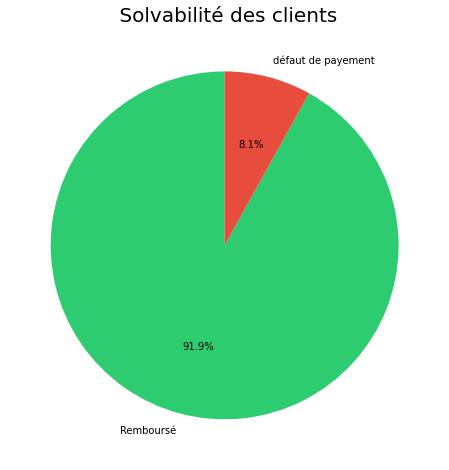

In [32]:
# Pieplot de solvabilité des clients du jeu d'entrainement
solvability_clients(data_application_train)


- 91.9% de prêt ont été remboursé et
- 8.1% de prêt  non remboursé .
- On constate qu'il y a beaucoup plus de prêts remboursé à temps que de prêts non remboursés.

### Missing 

In [33]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
               " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [34]:
# Missing values statistics
missing_values = missing_values_table(data_application_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Lorsque viendra le temps de construire nos modèles d'apprentissage automatique, nous devrons traiter ces valeurs manquantes
En modélisation, il y a des modèles tels que XGBoost peuvent gérer les valeurs manquantes sans imputation. 
Neamoins on peut remplacer les NaN, supprimer les colonnes avec un pourcentage élevé de valeurs manquantes (à voir plustard)

## Column Types

In [35]:
# Number of each type of column
data_application_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

On a:
- des floats
- des ints
- et des Object

In [36]:
# Number of unique classes in each object column
data_application_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

On peut voir qu'il y'a beaucoup de variable categoriel à encodé.


In [37]:
def nan_check(data):
    '''Check Missing Values'''
    total = data.isnull().sum()
    percent_1 = data.isnull().sum()/data.isnull().count()*100
    percent_2 = (np.round(percent_1, 2))
    missing_data = pd.concat([total, percent_2], 
                             axis=1, keys=['Total', '%']).sort_values('%', ascending=False)
    return missing_data

print('TOP 10 Missing values from Training dataset')
nan_check(data_application_train)[:10]



TOP 10 Missing values from Training dataset


,Total,%
COMMONAREA_MEDI,214865,69.87
COMMONAREA_AVG,214865,69.87
COMMONAREA_MODE,214865,69.87
NONLIVINGAPARTMENTS_MODE,213514,69.43
NONLIVINGAPARTMENTS_AVG,213514,69.43
NONLIVINGAPARTMENTS_MEDI,213514,69.43
FONDKAPREMONT_MODE,210295,68.39
LIVINGAPARTMENTS_MODE,210199,68.35
LIVINGAPARTMENTS_AVG,210199,68.35
LIVINGAPARTMENTS_MEDI,210199,68.35


In [38]:
print("Nb de colonnes dans l'échantillon d'apprentissage: " + str(len(nan_check(data_application_train))))

print("Nombre de colonnes dans l'échantillon d'apprentissage avec des valeurs manquantes: " + 
      str(len(nan_check(data_application_train)[nan_check(data_application_train)['Total']!=0])))

Nb de colonnes dans l'échantillon d'apprentissage: 122
Nombre de colonnes dans l'échantillon d'apprentissage avec des valeurs manquantes: 67


###  Outliers, valeurs atypiques, anormales

Un problème que nous voulons toujours surveiller lors de l'élaboration d'EDA est celui des anomalies dans les données. Celles-ci peuvent être dues à des nombres mal saisis, à des erreurs dans l'équipement de mesure ou à des mesures valides mais extrêmes.

In [39]:
data_application_train['DAYS_BIRTH'].describe()

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

Les nombres dans la colonne DAYS_BIRTH sont négatifs car ils sont enregistrés par rapport à la demande de prêt en cours. Pour voir ces statistiques en années, nous pouvons multiplier par -1 et diviser par le nombre de jours dans une année 

In [40]:
(data_application_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Ces âges semblent raisonnables. Il n'y a pas de valeurs aberrantes pour l'âge, que ce soit à l'extrémité supérieure ou inférieure.

Text(0.5, 1.0, 'Age du client')

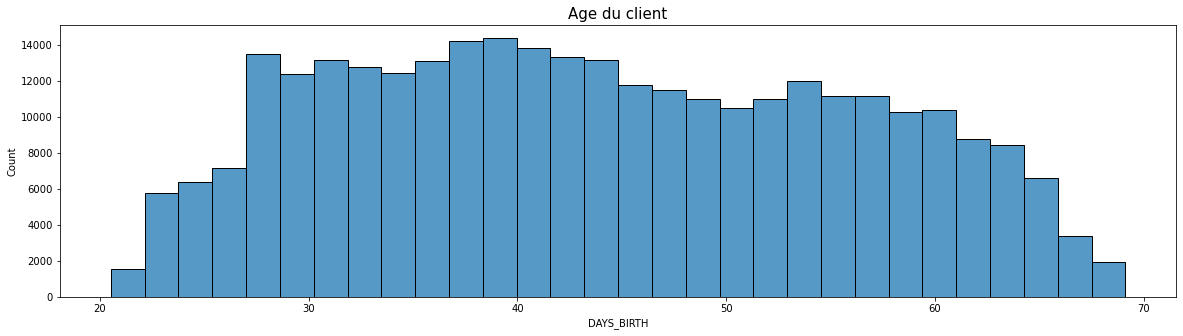

In [41]:
plt.figure(figsize=(20, 5))
sns.histplot((data_application_train['DAYS_BIRTH'] / -365), bins = 30).set_title('Age du client', fontsize = 15)


In [42]:
data_application_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

Cela ne semble pas correct ! La valeur maximale (en plus d'être positive) est d'environ 1000 ans

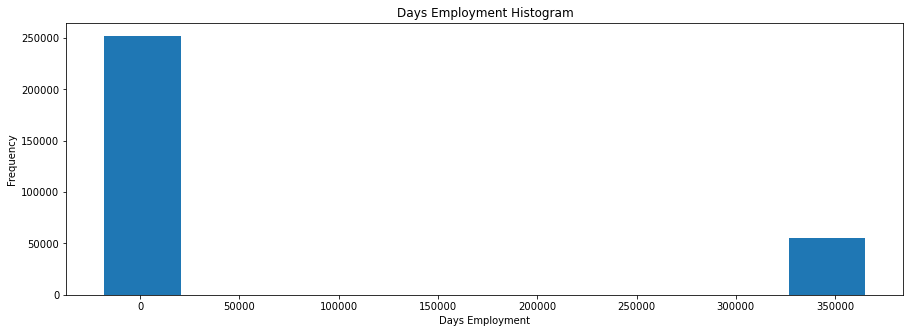

In [43]:
data_application_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram',figsize=(15,5));
plt.xlabel('Days Employment');

Les données ne sont pas  équilibrés. Le Max représente 1000 années (365243/365j). 

In [44]:
#data_application_test['DAYS_EMPLOYED_ANOM'] = data_application_test["DAYS_EMPLOYED"] == 365243
#data_application_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

#print('There are %d anomalies in the test data out of %d entries' % (data_application_test["DAYS_EMPLOYED_ANOM"].sum(), len(data_application_test)))


In [45]:
def stack_plot(data, xtick, col2='TARGET', col3='total'):
    ind = np.arange(data.shape[0])
    
    if len(data[xtick].unique())<5:
        plt.figure(figsize=(5,5))
    elif len(data[xtick].unique())>5 & len(data[xtick].unique())<10:
        plt.figure(figsize=(7,7))
    else:
        plt.figure(figsize=(15,15))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Prêts')
    plt.title('Nombre de prêts approuvés vs rejetés')
    plt.xticks(ticks=ind,rotation=90,labels= list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('capable', 'Pas capable'))
    plt.show()

In [46]:
def univariate_barplots(data, col1, col2='TARGET', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(data_application_train.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(data_application_train.groupby(col1)[col2].agg(total='count')).reset_index()['total']
    temp['Avg'] = pd.DataFrame(data_application_train.groupby(col1)[col2].agg(Avg='mean')).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

## CODE_GENDER

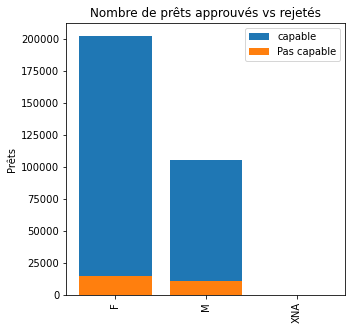

  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000
  CODE_GENDER  TARGET   total       Avg
0           F   14170  202448  0.069993
1           M   10655  105059  0.101419
2         XNA       0       4  0.000000


In [47]:
univariate_barplots(data_application_train, col1='CODE_GENDER',
                    col2='TARGET', top=False)

#### Les femmes ont contracté beaucoup plus de prêts que les hommes
- Les femmes ont contracté un total de 202 448 prêts,
- Les hommes n'ont contracté que 105 059 prêts.
Les hommes sont légèrement plus capables de rembourser le prêt que les femmes
IL ya 4 code genre mais comme code genre = XNA ne fournit pas plus d'information , on va le supprimé plustard

## FLAG_OWN_CAR

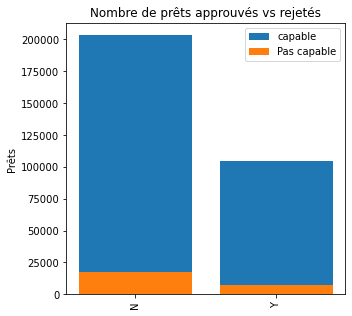

  FLAG_OWN_CAR  TARGET   total       Avg
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437
  FLAG_OWN_CAR  TARGET   total       Avg
0            N   17249  202924  0.085002
1            Y    7576  104587  0.072437


In [48]:
univariate_barplots(data_application_train, col1='FLAG_OWN_CAR',
                    col2='TARGET', top=False)

- La plupart des demandeurs de prêts ne possèdent pas de voiture.
- Il n'y a pas beaucoup de différence dans le statut de remboursement du prêt pour le client sur la base de posseder une voiture (8,5 % pas de voiture et 7,2 % possedant une voiture).
- Nous pouvons conclure que cette fonctionnalité n'est pas très utile.

## NAME_FAMILY_STATUS

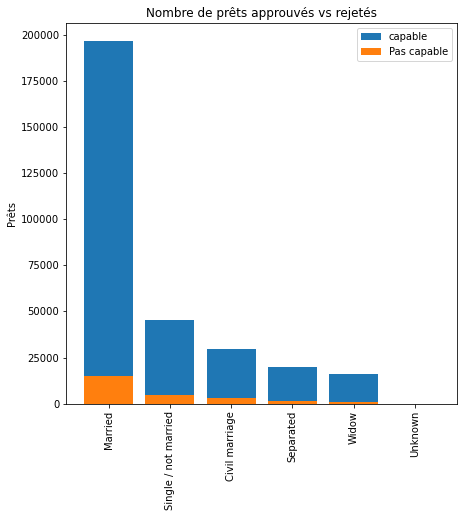

     NAME_FAMILY_STATUS  TARGET   total       Avg
1               Married   14850  196432  0.075599
3  Single / not married    4457   45444  0.098077
0        Civil marriage    2961   29775  0.099446
2             Separated    1620   19770  0.081942
5                 Widow     937   16088  0.058242
     NAME_FAMILY_STATUS  TARGET  total       Avg
3  Single / not married    4457  45444  0.098077
0        Civil marriage    2961  29775  0.099446
2             Separated    1620  19770  0.081942
5                 Widow     937  16088  0.058242
4               Unknown       0      2  0.000000


In [49]:
univariate_barplots(data_application_train, col1='NAME_FAMILY_STATUS',
                    col2='TARGET', top=False)

- Les personnes mariées demandent le plus grand nombre de prêts et le nombre de personnes jugées incapables de rembourser est également le plus élevé (9,8%).

In [50]:
def plot_stat(data, feature, title) : 
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.countplot(y=feature, data=data, order=data[feature].value_counts(ascending=False).index)
    ax.set_title(title)

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width()/len(data[feature]))
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')
                
                
                
                
def plot_percent_target1(data, feature, title) : 
    
    cat_perc = data[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    ax, fig = plt.subplots(figsize=(20,8)) 
    ax = sns.barplot(y=feature, x='TARGET', data=cat_perc)
    ax.set_title(title)
    ax.set_xlabel("")
    ax.set_ylabel("Percent of target with value 1")

    for p in ax.patches:
                percentage = '{:.1f}%'.format(100 * p.get_width())
                x = p.get_x() + p.get_width()
                y = p.get_y() + p.get_height()/2
                ax.annotate(percentage, (x, y), fontsize=20, fontweight='bold')

                                   -------------------------------------------------------


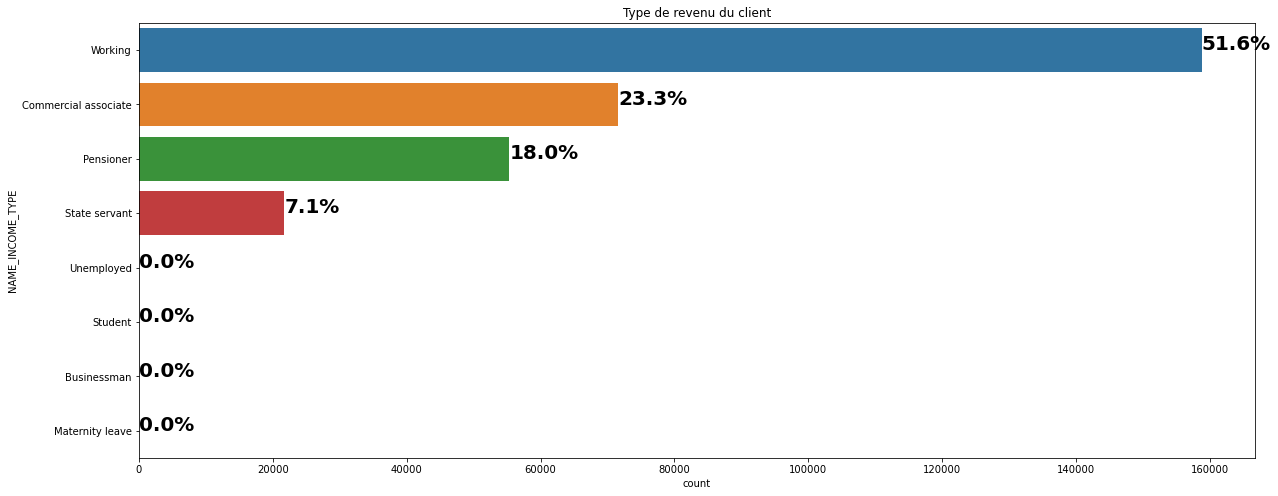

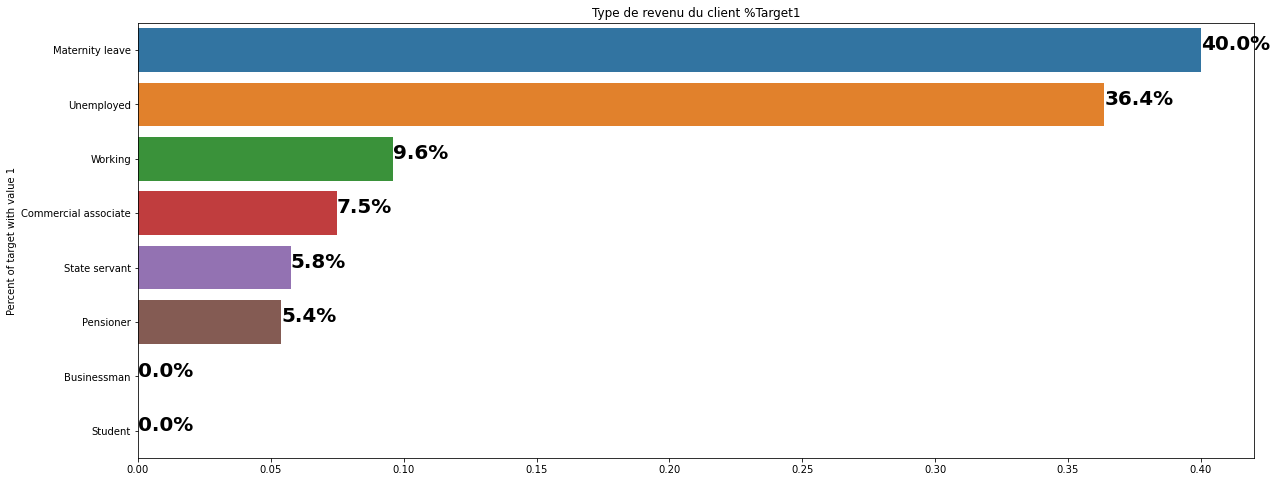

In [51]:
#NAME_INCOME_TYPE
plot_stat(data_application_train, 'NAME_INCOME_TYPE',"Type de revenu du client")
print("                                   -------------------------------------------------------")
plot_percent_target1(data_application_train, 'NAME_INCOME_TYPE',"Type de revenu du client %Target1")



- La plupart des demandeurs de prêts sont des gens qui travail, suivis par un associé commercial.

- Les demandeurs avec le type de revenu Congé de maternité ont  40% de prêts non remboursés, suivis des chômeurs (37%). Les autres types de revenus sont inférieurs à la moyenne de 10% pour ne pas rembourser les prêts.


# NAME_HOUSING_TYPE

                                   -------------------------------------------------------


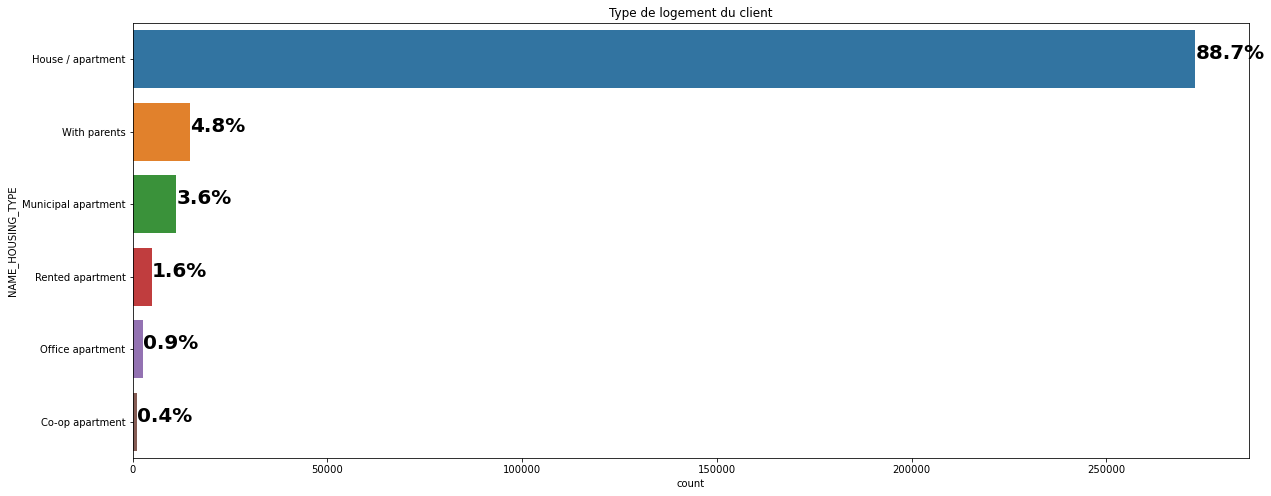

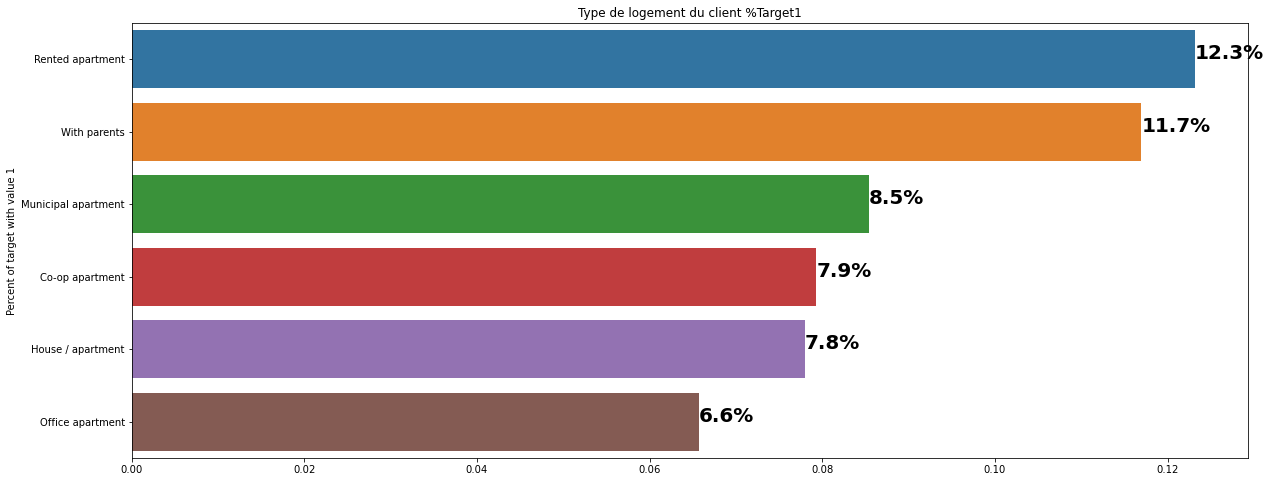

In [52]:

#NAME_HOUSING_TYPE
plot_stat(data_application_train, 'NAME_HOUSING_TYPE',"Type de logement du client")
print("                                   -------------------------------------------------------")
plot_percent_target1(data_application_train, 'NAME_HOUSING_TYPE',"Type de logement du client %Target1")

- Plus de 88% de demandeurs de crédits vivent en maison ou appartement
- Les locateurs d'appartements (non propriétaires de leur résidence principale), ainsi que ceux qui vivent chez leurs parents, ont un taux de non-remboursement  de 12%.

## Correlations

Maintenant que nous avons traité les variables catégorielles et les valeurs aberrantes, continuons avec l'EDA. Une façon d'essayer de comprendre les données consiste à rechercher des corrélations entre les caractéristiques et la cible. Nous pouvons calculer le coefficient de corrélation de Pearson entre chaque variable et la cible en utilisant la méthode de trame de données .corr.

Le coefficient de corrélation n'est pas la meilleure méthode pour représenter la "pertinence" d'une caractéristique, mais il nous donne une idée des relations possibles au sein des données. Voici quelques interprétations générales de la valeur absolue du coefficient de corrélation :

- 0.00-0.19 "très faible"
- 0.20-0.39 "faible"
- 0.40-0.59 "modéré"
- 0.60-0.79 "fort"
- 0.80-1.0 "très fort"

In [53]:
# Find correlations with the target and sort
correlations = data_application_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64

Most Negative Correlations:
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE              -0.039645


Examinons quelques-unes des corrélations les plus significatives : 
- DAYS_BIRTH est la corrélation la plus positive. (sauf pour TARGET car la corrélation d'une variable avec elle-même est toujours 1 !) 
- En regardant la documentation, DAYS_BIRTH est l'âge en jours du client au moment du prêt en jours négatifs (quelle qu'en soit la raison !). 
- La corrélation est positive, mais la valeur de cette caractéristique est en fait négative, ce qui signifie qu'à mesure que le client vieillit, il est moins susceptible de faire défaut sur son prêt (c'est-à-dire la cible == 0). C'est un peu déroutant, nous prendrons donc la valeur absolue de la caractéristique, puis la corrélation sera négative.

In [54]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = data_application_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

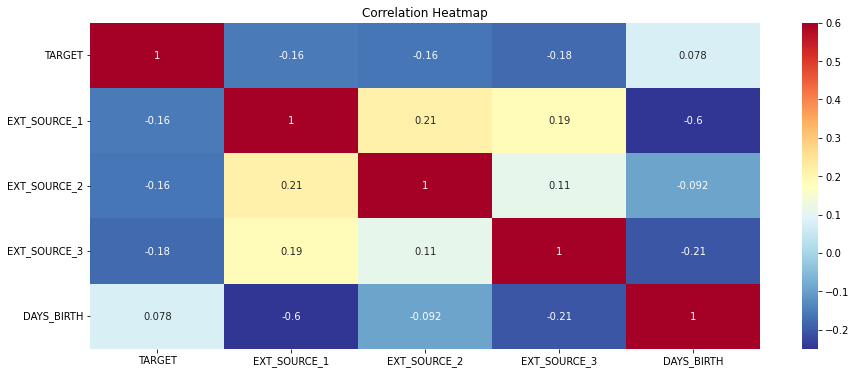

In [55]:
plt.figure(figsize = (15, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap')

- Les trois caractéristiques EXT_SOURCE ont des corrélations négatives avec la cible, ce qui indique qu'à mesure que la valeur de EXT_SOURCE augmente, le client est plus susceptible de rembourser le prêt. 
- Nous pouvons également voir que DAYS_BIRTH est positivement corrélé avec EXT_SOURCE_1 indiquant que l'un des facteurs de ce score est peut-être l'âge du client.

- Ensuite, nous pouvons examiner la distribution de chacune de ces caractéristiques colorées par la valeur de la cible. Cela nous permettra de visualiser l'effet de cette variable sur la cible.

In [56]:
#Plot distribution of one feature
def plot_distribution(feature, title):
    plt.figure(figsize=(20,6))

    t0 = data_application_train.loc[data_application_train['TARGET'] == 0]
    t1 = data_application_train.loc[data_application_train['TARGET'] == 1]

    
    sns.kdeplot(t0[feature].dropna(), color='blue', label="TARGET = 0")
    sns.kdeplot(t1[feature].dropna(), color='red', label="TARGET = 1")
    plt.title(title)
    plt.ylabel('')
    plt.legend()

                                   -------------------------------------------------------
                                   -------------------------------------------------------
                                   -------------------------------------------------------
                                   -------------------------------------------------------


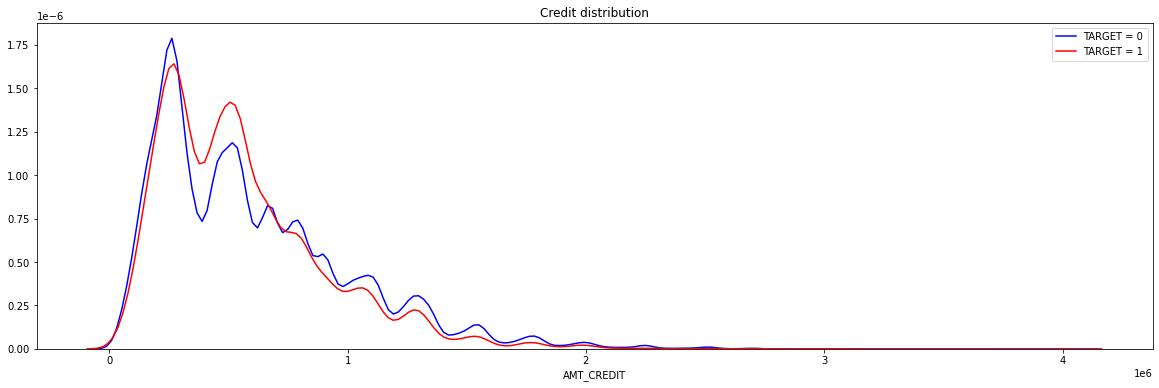

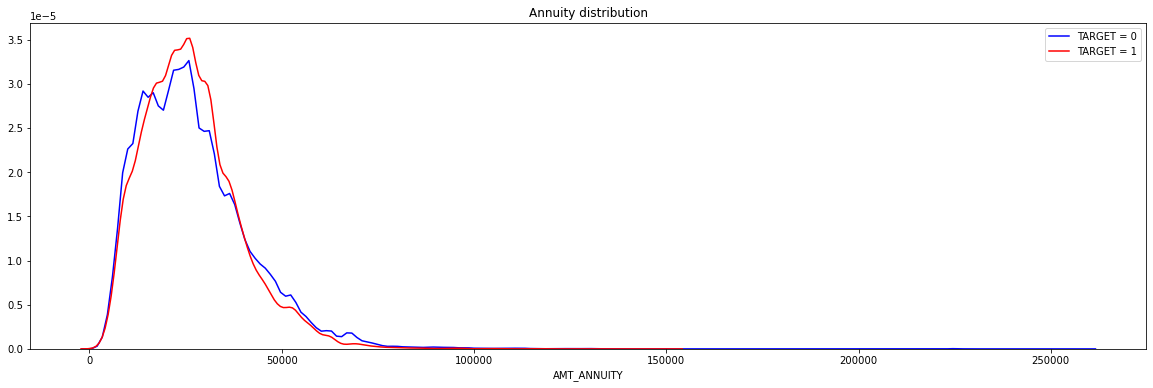

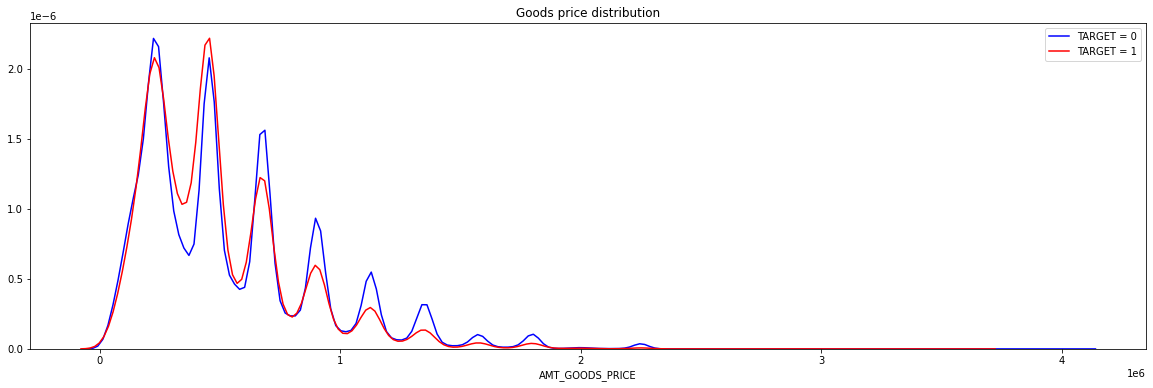

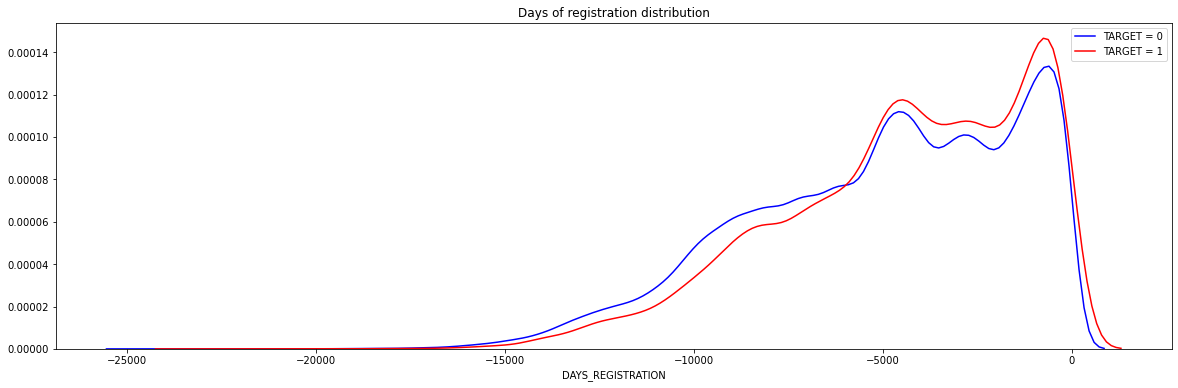

In [57]:
plot_distribution('AMT_CREDIT', "Credit distribution")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_ANNUITY', "Annuity distribution")
print("                                   -------------------------------------------------------")
plot_distribution('AMT_GOODS_PRICE', "Goods price distribution")
print("                                   -------------------------------------------------------")
plot_distribution('DAYS_REGISTRATION', "Days of registration distribution")
print("                                   -------------------------------------------------------")

## Fonctions

In [59]:
#@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    

#Encodage à chaud pour les colonnes catégorielles avec get_dummies
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns



## 2.2 Concatenation des data 

In [60]:
#Create a simple dataset with the train / test merge app
data = data_application_train.append(data_application_test)



In [61]:
print('Train:' + str(data_application_train.shape))
print('Test:' + str(data_application_test.shape))
print('>>> Data:' + str(data.shape))



Train:(307511, 122)
Test:(48744, 121)
>>> Data:(356255, 122)


In [62]:
#Now just in case, let's check if we've got it right
data.TARGET.isna().sum()



48744

In [63]:
sum(data.SK_ID_CURR[data.TARGET.isna()] == data_application_test.SK_ID_CURR) #all is good



48744

In [64]:
sum(data.SK_ID_CURR.isin(data_application_test.SK_ID_CURR)) == len(data_application_test) #nothing else to prove

True

In [65]:

display(data_bureau.shape)

(1716428, 17)

In [66]:
#Total number of previous credits taken by each customer
previous_loan_counts = data_bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(
                                       columns = {'SK_ID_BUREAU': 'PREVIOUS_LOANS_COUNT'})
previous_loan_counts.head()



,SK_ID_CURR,PREVIOUS_LOANS_COUNT
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3


In [67]:
#Merge this new column in our data sample
data = data.merge(previous_loan_counts, on='SK_ID_CURR', how='left')
data.shape

(356255, 123)

In [68]:
display(data_bureau_balance.head())

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [69]:
#Monthly average balances of previous credits in Credit Bureau.
bureau_bal_mean = data_bureau_balance.groupby('SK_ID_BUREAU', as_index=False).mean().rename(columns = 
                                        {'MONTHS_BALANCE': 'MONTHS_BALANCE_MEAN'})
bureau_bal_mean.head()



,SK_ID_BUREAU,MONTHS_BALANCE_MEAN
0,5001709,-48.0
1,5001710,-41.0
2,5001711,-1.5
3,5001712,-9.0
4,5001713,-10.5


In [70]:
bureau_full = data_bureau.merge(bureau_bal_mean, on='SK_ID_BUREAU', how='left')
bureau_full.drop('SK_ID_BUREAU', axis=1, inplace=True)
display(bureau_full.head())
display(bureau_full.shape)

,SK_ID_CURR,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE_MEAN
0,215354,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN,NaN
1,215354,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN,NaN
2,215354,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN,NaN
3,215354,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN,NaN
4,215354,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN,NaN


(1716428, 17)

In [71]:
bureau_mean = bureau_full.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_BUR_MEAN_')
bureau_mean = bureau_mean.rename(columns = {'PREV_BUR_MEAN_SK_ID_CURR' : 'SK_ID_CURR'})
bureau_mean.shape



(305811, 14)

In [72]:
#Merge all this features with our data sample
data = data.merge(bureau_mean, on='SK_ID_CURR', how='left')
data.shape

(356255, 136)

In [73]:
display(data_previous_application.head())
display(data_previous_application.shape)



,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


(1670214, 37)

In [74]:
#Check 
len(data_previous_application.SK_ID_CURR.isin(data.SK_ID_CURR)) == len(data_previous_application)

True

In [75]:
#Number of previous applications of the clients to Home Credit
previous_application_counts = data_previous_application.groupby('SK_ID_CURR', 
                                                           as_index=False)['SK_ID_PREV'].count().rename(
                                                           columns = {'SK_ID_PREV': 'PREVIOUS_APPLICATION_COUNT'})
previous_application_counts.head()



,SK_ID_CURR,PREVIOUS_APPLICATION_COUNT
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2


In [76]:
#Merge this new column in our data sample
data = data.merge(previous_application_counts, on='SK_ID_CURR', how='left')
data.shape



(356255, 137)

In [77]:
display(data_credit_card_balance.shape)

(3840312, 23)

In [78]:
data_credit_card_balance.drop('SK_ID_CURR', axis=1, inplace=True)



In [79]:
credit_card_balance_mean = data_credit_card_balance.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('CARD_MEAN_')
credit_card_balance_mean.rename(columns = {'CARD_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
credit_card_balance_mean.shape

(104307, 21)

In [80]:
#Merge with previous_application
data_previous_application = data_previous_application.merge(credit_card_balance_mean, on='SK_ID_PREV', how='left')
data_previous_application.shape



(1670214, 57)

In [81]:
display(data_installments_payments.shape)

(13605401, 8)

In [82]:
data_installments_payments.drop('SK_ID_CURR', axis=1, inplace=True)

In [83]:
install_pay_mean = data_installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('INSTALL_MEAN_')
install_pay_mean.rename(columns = {'INSTALL_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
install_pay_mean.shape



(997752, 7)

In [84]:
#Merge with previous_application
data_previous_application = data_previous_application.merge(install_pay_mean, on='SK_ID_PREV', how='left')
data_previous_application.shape



(1670214, 63)

In [85]:
display(data_POS_CASH_balance.shape)

(10001358, 8)

In [86]:
data_POS_CASH_balance.drop('SK_ID_CURR', axis=1, inplace=True)



In [87]:
POS_mean = data_installments_payments.groupby('SK_ID_PREV', as_index=False).mean().add_prefix('POS_MEAN_')
POS_mean.rename(columns = {'POS_MEAN_SK_ID_PREV' : 'SK_ID_PREV'}, inplace=True)
POS_mean.shape



(997752, 7)

In [88]:
#Merge with previous_application
data_previous_application = data_previous_application.merge(POS_mean, on='SK_ID_PREV', how='left')
data_previous_application.shape



(1670214, 69)

In [89]:
display(data_previous_application.head())
display(data_previous_application.shape)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,INSTALL_MEAN_DAYS_INSTALMENT,INSTALL_MEAN_DAYS_ENTRY_PAYMENT,INSTALL_MEAN_AMT_INSTALMENT,INSTALL_MEAN_AMT_PAYMENT,POS_MEAN_NUM_INSTALMENT_VERSION,POS_MEAN_NUM_INSTALMENT_NUMBER,POS_MEAN_DAYS_INSTALMENT,POS_MEAN_DAYS_ENTRY_PAYMENT,POS_MEAN_AMT_INSTALMENT,POS_MEAN_AMT_PAYMENT
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,-42.0,-42.000000,17284.275000,17284.275000,2.000000,1.0,-42.0,-42.000000,17284.275000,17284.275000
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,-74.0,-83.200000,25188.615000,25188.615000,1.000000,3.0,-74.0,-83.200000,25188.615000,25188.615000
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,-151.0,-159.222222,15060.735000,15060.735000,1.000000,5.0,-151.0,-159.222222,15060.735000,15060.735000
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,-332.0,-339.090909,51193.943182,51193.943182,1.090909,6.0,-332.0,-339.090909,51193.943182,51193.943182
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


(1670214, 69)

In [90]:
prev_appl_mean = data_previous_application.groupby('SK_ID_CURR', as_index=False).mean().add_prefix('PREV_APPL_MEAN_')
prev_appl_mean.rename(columns = {'PREV_APPL_MEAN_SK_ID_CURR' : 'SK_ID_CURR'}, inplace=True)
prev_appl_mean = prev_appl_mean.drop('PREV_APPL_MEAN_SK_ID_PREV', axis=1)



In [91]:
display(prev_appl_mean.shape)

(338857, 52)

In [92]:
#Reminder…
print('data shape', data.shape)

data shape (356255, 137)


In [93]:
#Last merge with our data sample
data = data.merge(prev_appl_mean, on='SK_ID_CURR', how='left')
#data.set_index('SK_ID_CURR', inplace=True)
display(data.head())
display(data.shape)



,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_INSTALL_MEAN_AMT_PAYMENT,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_VERSION,PREV_APPL_MEAN_POS_MEAN_NUM_INSTALMENT_NUMBER,PREV_APPL_MEAN_POS_MEAN_DAYS_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_DAYS_ENTRY_PAYMENT,PREV_APPL_MEAN_POS_MEAN_AMT_INSTALMENT,PREV_APPL_MEAN_POS_MEAN_AMT_PAYMENT
0,100002,1.0,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,-295.000000,-315.421053,11559.247105,11559.247105,1.052632,10.000000,-295.000000,-315.421053,11559.247105,11559.247105
1,100003,0.0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,-1164.333333,-1171.781746,78558.479286,78558.479286,1.047619,4.666667,-1164.333333,-1171.781746,78558.479286,78558.479286
2,100004,0.0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,-754.000000,-761.666667,7096.155000,7096.155000,1.333333,2.000000,-754.000000,-761.666667,7096.155000,7096.155000
3,100006,0.0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,-260.666667,-285.966667,241944.225000,241944.225000,1.400000,3.166667,-260.666667,-285.966667,241944.225000,241944.225000
4,100007,0.0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,-1087.881319,-1090.768539,12122.995738,11671.540210,1.129412,6.843956,-1087.881319,-1090.768539,12122.995738,11671.540210


(356255, 188)

## Preprocess

In [94]:
 # NaN values for DAYS_EMPLOYED: 365.243 -> nan
data['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
data['DAYS_EMPLOYED_PERC'] = data['DAYS_EMPLOYED'] / data['DAYS_BIRTH']
data['INCOME_CREDIT_PERC'] = data['AMT_INCOME_TOTAL'] / data['AMT_CREDIT']
data['INCOME_PER_PERSON'] = data['AMT_INCOME_TOTAL'] / data['CNT_FAM_MEMBERS']
data['ANNUITY_INCOME_PERC'] = data['AMT_ANNUITY'] / data['AMT_INCOME_TOTAL']
data['PAYMENT_RATE'] = data['AMT_ANNUITY'] / data['AMT_CREDIT']

In [95]:
data.shape

(356255, 193)

In [98]:
#Display correlations with features engineering
print('Most Positive Correlations:\n', data.corr()['TARGET'].sort_values().tail(15))
print("--------------------------")
print('Most Negative Correlations:\n', data.corr()['TARGET'].sort_values().head(15))

Most Positive Correlations:
 REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
PREV_BUR_MEAN_DAYS_CREDIT_UPDATE                     0.068927
PREV_APPL_MEAN_CARD_MEAN_AMT_INST_MIN_REGULARITY     0.074204
DAYS_EMPLOYED                                        0.074958
PREV_BUR_MEAN_MONTHS_BALANCE_MEAN                    0.076424
DAYS_BIRTH                                           0.078239
PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_CURRENT        0.080885
PREV_APPL_MEAN_CARD_MEAN_AMT_RECEIVABLE_PRINCIPAL    0.085491
PREV_APPL_MEAN_CARD_MEAN_AMT_RECIVABLE               0.085963
PREV_APPL_MEAN_CARD_MEAN_AMT_TOTAL_RECEIVABLE        0.085967
PREV_APPL_MEAN_CARD_MEAN_AMT_BALANCE                 0.086693
PREV_BUR_MEAN_DAYS_CREDIT                            0.089729
PREV_APPL_MEAN_CARD_MEAN_CNT_DRAWINGS_ATM_CURRENT    0.102917
TARGET                                               1.000000
Name: TARGET, dtype: float64
------------

In [99]:
data.to_csv('merged_data.csv', index=True)


In [155]:
data_train_T = data[data['SK_ID_CURR'].isin(data_application_train.SK_ID_CURR)]
data_test_T = data[data['SK_ID_CURR'].isin(data_application_test.SK_ID_CURR)]

In [156]:
print('Training Features shape with categorical columns: ', data_train_T.shape)
print('Testing Features shape with categorical columns: ', data_test_T.shape)

Training Features shape with categorical columns:  (307511, 193)
Testing Features shape with categorical columns:  (48744, 193)


In [157]:
import re
data_train_T.replace([np.inf, -np.inf], np.nan, inplace=True)
data_train_T.fillna(0, inplace=True)
data_test_T.replace([np.inf, -np.inf], np.nan, inplace=True)
data_test_T.fillna(0, inplace=True)
#data_train_T = data_train_T.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
#data_test_T = data_test_T.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

In [158]:
data_train_T.isna().sum().sum()

0

In [102]:
data_train = data[data['SK_ID_CURR'].isin(data_application_train.SK_ID_CURR)]
data_test = data[data['SK_ID_CURR'].isin(data_application_test.SK_ID_CURR)]

data_test = data_test.drop('TARGET', axis=1)



In [103]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)

Training Features shape with categorical columns:  (307511, 193)
Testing Features shape with categorical columns:  (48744, 192)


In [104]:


from sklearn.preprocessing import LabelEncoder

# Create a label encoder object
le = LabelEncoder()
count = 0

# Iterate through the columns
for col in data_train:
    # Si 2 catégories uniques ou moins
    if data_train.loc[:,col].dtype == 'object' and len(list(data_train.loc[:,col].unique())) <= 2:
        # Train on the training data
        le.fit(data_train.loc[:,col])
        # Transform both training and testing data
        data_train.loc[:,col] = le.transform(data_train.loc[:,col])
        data_test.loc[:,col] = le.transform(data_test.loc[:,col])

        count += 1
            
print('%d columns were label encoded.' % count)

3 columns were label encoded.


In [159]:
data_train_T = pd.get_dummies(data_train_T)
data_test_T = pd.get_dummies(data_test_T)

In [160]:
print('Training Features shape with categorical columns: ', data_train_T.shape)
print('Testing Features shape with categorical columns: ', data_test_T.shape)

Training Features shape with categorical columns:  (307511, 323)
Testing Features shape with categorical columns:  (48744, 320)


In [161]:
data_train_T

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1.0,0,202500.0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,...,0,0,0,0,0,1,0,0,1,0
1,100003,0.0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,...,1,0,0,0,0,0,0,0,1,0
2,100004,0.0,0,67500.0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,...,0,0,0,0,0,0,0,1,0,0
3,100006,0.0,0,135000.0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,...,0,0,0,0,0,0,0,1,0,0
4,100007,0.0,0,121500.0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0.0,0,157500.0,254700.0,27558.0,225000.0,0.032561,-9327,-236.0,...,0,0,0,0,0,1,0,0,1,0
307507,456252,0.0,0,72000.0,269550.0,12001.5,225000.0,0.025164,-20775,0.0,...,0,0,0,0,0,1,0,0,1,0
307508,456253,0.0,0,153000.0,677664.0,29979.0,585000.0,0.005002,-14966,-7921.0,...,0,0,0,0,1,0,0,0,1,0
307509,456254,1.0,0,171000.0,370107.0,20205.0,319500.0,0.005313,-11961,-4786.0,...,0,0,0,0,0,1,0,0,1,0


In [107]:
data_train = pd.get_dummies(data_train)
data_test = pd.get_dummies(data_test)

In [108]:
print('Training Features shape with categorical columns: ', data_train.shape)
print('Testing Features shape with categorical columns: ', data_test.shape)

Training Features shape with categorical columns:  (307511, 314)
Testing Features shape with categorical columns:  (48744, 310)


In [162]:
#Align the datasets
data_train_T, data_test_T = data_train_T.align(data_test_T, join='inner', axis=1)

In [163]:
print(data_train_T.shape)
print(data_test_T.shape)

(307511, 320)
(48744, 320)


In [111]:
TARGET = data_train.TARGET #save our TARGET variable
data_train.drop('TARGET', axis=1, inplace=True) #remove TARGET from train

#Align the datasets
data_train, data_test = data_train.align(data_test, join='inner', axis=1)



In [112]:
print(data_train.shape)
print(data_test.shape)



(307511, 310)
(48744, 310)


In [115]:
#Copy before imputation of missing values
train = data_train.copy()
test = data_test.copy()
train.shape, test.shape



((307511, 310), (48744, 310))

### Traitement des NaN

In [116]:
TARGET.isna().sum().sum()

0

In [117]:
test.isna().sum().sum()

2277621

In [118]:
train.isna().sum().sum()

15543707

In [164]:
from sklearn.impute import SimpleImputer

print('Missing values in train data: ', sum(data_train.isnull().sum()))
print('Missing values in test data: ', sum(data_test.isnull().sum()))

print('Missing values in data_train_T data: ', sum(data_train_T.isnull().sum()))
print('Missing values in data_test_T data: ', sum(data_test_T.isnull().sum()))

Missing values in train data:  0
Missing values in test data:  0
Missing values in data_train_T data:  0
Missing values in data_test_T data:  0


In [123]:
imputer = SimpleImputer(strategy='median')
data_train.iloc[:,:] = imputer.fit_transform(data_train)

In [124]:
imputer = SimpleImputer(strategy='median')
data_test.iloc[:,:] = imputer.fit_transform(data_test)

In [125]:
#Check Imputation step
sum(data_train.isnull().sum())

0

In [126]:
sum(data_train_T.isnull().sum())

0


### Standardisation des données

In [127]:
from sklearn.preprocessing import MinMaxScaler

#Fit scaler to our training data
scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(data_train)
scaled_train = scaler.transform(data_train)

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit(data_test)
scaled_test = scaler.transform(data_test)

In [128]:
#In order to keep our column names we include scaled_values to our train/test dataframes like this
train_df = pd.DataFrame(scaled_train, index=data_train.index, columns=data_train.columns)
test_df = pd.DataFrame(scaled_test, index=data_test.index, columns=data_test.columns)

In [129]:
train_df = train_df.select_dtypes(include='float').astype('int')
test_df = test_df.select_dtypes(include='float').astype('int')

In [130]:
test_df.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
307511,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
307512,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307513,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307514,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
307515,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [131]:
test_df.dtypes.unique()

array([dtype('int32')], dtype=object)

In [165]:
#Fit scaler to our training data
scaler_T = MinMaxScaler(feature_range = (0, 1))
scaler_T.fit(data_train_T)
scaled_train_T = scaler_T.transform(data_train_T)

#scaler = MinMaxScaler(feature_range = (0, 1))
scaler_T.fit(data_test_T)
scaled_test_T = scaler_T.transform(data_test_T)

In [166]:
#In order to keep our column names we include scaled_values to our train/test dataframes like this
data_train_T = pd.DataFrame(scaled_train_T, index=data_train_T.index, columns=data_train_T.columns)
data_test_T = pd.DataFrame(scaled_test_T, index=data_test_T.index, columns=data_test_T.columns)

In [167]:
data_train_T.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0.000000,1.0,0.0,0.001512,0.090287,0.095729,0.086667,0.256321,0.888839,0.964437,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.000003,0.0,0.0,0.002089,0.311736,0.138353,0.278889,0.045016,0.477114,0.933676,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.000006,0.0,0.0,0.000358,0.022472,0.026160,0.033333,0.134897,0.348534,0.987439,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.000011,0.0,0.0,0.000935,0.066837,0.115053,0.073333,0.107023,0.350846,0.830337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.000014,0.0,0.0,0.000819,0.116854,0.084742,0.126667,0.392880,0.298591,0.830393,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [168]:
data_train_T = data_train_T.select_dtypes(include='float').astype('int')
data_test_T = data_test_T.select_dtypes(include='float').astype('int')

In [169]:
data_train_T.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_0,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
data.to_csv('data_df.csv', index=True)
test_df.to_csv('data_test.csv', index=True)
train_df.to_csv('data_train.csv', index=True)
data_test_T.to_csv('data_test_T.csv', index=True)
data_train_T.to_csv('data_train_T.csv', index=True)
TARGET.to_csv('TARGET.csv', index=True)

In [170]:
data_test_T.to_csv('data_test_T.csv', index=True)
data_train_T.to_csv('data_train_T.csv', index=True)